# Predicting the forest cover type : Kaggle competition

I used scikit learn and Jupyter notebook for this exercise.
The main reason is that I quickly realized that the scikit-learn library of Python was much more powerful than the Mllib of Spark. Moreover, using the DataBricks Community Edition was limiting me in terms of computational time that I could use for parameter tuning. Actually, I have done quite some computational intensive grid searches and I could not have afforded that with DataBricks.

In the following, you will find a reviewed version of the notebook I used to obtain a score of 0.96077 on Kaggle with explanations of the thinking behind my methodology.

# Outline
> - I - Introduction
> - II - Libraries import, plot parameters, useful functions
> - III - Data loading
> - IV - First tests
> - V - Feature adjusting
> - VI - Classification using Extra Tree Classifier
> - VII - Conclusion and outlook

# I - Introduction

In this competition I was asked to predict 7 different forest cover types from strictly cartographic variables. The data was in raw form (not scaled) and contained binary columns of data for qualitative independent variables such as wilderness areas and soil type.

# II - Libraries import, plot parameters, useful functions

In [1]:
# Libraries import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pylab as plt
from sklearn.multiclass import OneVsRestClassifier

# Plot parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Useful functions
def evaluate_performance(val_y, val_predictions):
    ''' Based on the validation data and computed predictions, evaluates the performance of a chosen model '''
    
    print('Evaluation of the model performance:')
    print(classification_report(val_y,val_predictions))
    print("Accuracy :", accuracy_score(val_y,val_predictions))
    
def feature_importance(model, features):
    ''' Calculates the sorted features by importance for a given model '''
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    df = pd.DataFrame(importances[indices], features.columns[indices])  
    
    #Plot the order of inportance of the features
    fig = plt.figure(figsize=(20,8)) 
    ax = fig.add_subplot(111)
    df.plot(kind='bar', ax=ax, label='Features', color = 'bg', legend=False)
    plt.title("Sorted features by importance")
    plt.ylabel("Importance") 
    
def undo_categorical_soil(X):
    ''' Group binary columns of soil types into one single column called Soil_Type'''
    X['Soil_Type'] = np.zeros([X.shape[0],1])    
    for soil in soils:
        X.iloc[X.index[X[soil] == 1].tolist(),-1] = int(soil[9:])
    X = X.drop(columns=soils)
    
    return X  

def undo_categorical_wilderness(X):
    ''' Group binary columns of wilderness areas into one single column called Wilderness_Area'''
    X['Wilderness_Area'] = np.zeros([X.shape[0],1])
    for area in wild_areas:
        X.iloc[X.index[X[area] == 1].tolist(),-1] = int(area[-1])    
    X = X.drop(columns=wild_areas)    
    
    return X

/cal/homes/aordonez/miniconda3/envs/MY_ENV/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/cal/homes/aordonez/miniconda3/envs/MY_ENV/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# II - Data loading

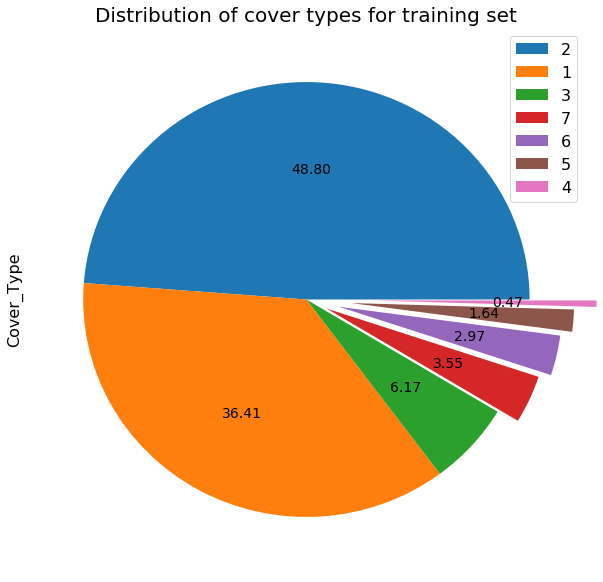

In [2]:
# Path of the file to read
file_path = '/cal/homes/aordonez/Downloads/'

# Train data
train_data = pd.read_csv(file_path + "train-set.csv")

# Test data
test_data = pd.read_csv(file_path + "test-set.csv")

# Create X (training) and test_X (test)
X = train_data.copy()
test_X = test_data.copy()

# Create y
y = train_data.Cover_Type

# Remove Id Columns from X and test_X
X = X.drop(columns=['Id','Cover_Type'])
test_X = test_X.drop(columns='Id')

# Pie chart
counts = train_data['Cover_Type'].value_counts()
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111)
explode = (0, 0, 0,0.1,0.15,0.2,0.3)
counts.plot(kind='pie', autopct='%.2f', labels=['','','','','','',''], ax=ax, 
            fontsize = 14, title='Distribution of cover types for training set', explode=explode)
plt.legend(labels=counts.index, loc="best")

### Comment
From the figure above, it clearly appears that cover types 1 and 2 are dominant over the 5 others for the training set. Therefore, training a model that accurately predicts those  will probably give me a good score.

# III - First tests

In order to be able to test several models, several cross-validations, etc., I decided to do not work on my entire training set and to split it into 2 datasets: train_X (80%) and val_X (20%) with their corresponding labels (train_y, val_y). The first set will be used for training my models and the second one will be used to validate whether the chosen approach is good enough. Once I consider that I have trained a convenient model I can submit my final results to Kaggle based on the provided test set. 

Note that the pie charts shown below illustrate that for the splitted training and validation sets, cover types 1 and 2 are still dominant over the others.

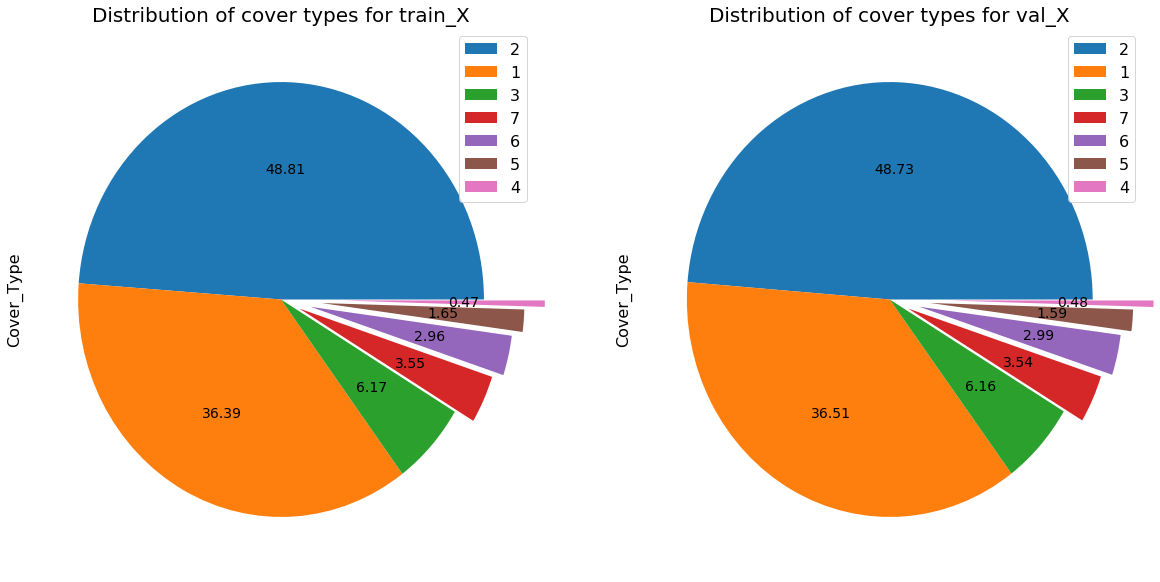

In [3]:
# Split into training (80%) and validation (20%)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1109)

# Pie chart for training and validation sets
fig = plt.figure(figsize=(20,10)) 
counts = train_y.value_counts()
ax = fig.add_subplot(121)
explode = (0, 0, 0,0.1,0.15,0.2,0.3)
counts.plot(kind='pie', autopct='%.2f', labels=['','','','','','',''], ax=ax, 
            fontsize = 14, title='Distribution of cover types for train_X', explode=explode)
plt.legend(labels=counts.index, loc="best")

counts = val_y.value_counts()
ax = fig.add_subplot(122)
counts.plot(kind='pie', autopct='%.2f', labels=['','','','','','',''], ax=ax, 
            fontsize = 14, title='Distribution of cover types for val_X', explode=explode)
plt.legend(labels=counts.index, loc="best")

For my first tests, I applied to the data 4 different types of models: 
- Logistic regression
- Decision Tree Classifier
- Random forest Classifier
- Extra Tree Classifier

to see what would happen. 
The results are shown below.

In [4]:
# Logistic Regression
clc = LogisticRegression()

# Make validation predictions with fit and predict
val_predictions = clc.fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.70      0.67      0.68     38605
          2       0.73      0.81      0.76     51525
          3       0.62      0.86      0.72      6519
          4       0.63      0.18      0.28       508
          5       0.27      0.01      0.02      1684
          6       0.39      0.05      0.09      3163
          7       0.71      0.44      0.54      3740

avg / total       0.69      0.71      0.69    105744

Accuracy : 0.7064230594643668


In [5]:
# Decision Tree
clc = DecisionTreeClassifier()

# Make validation predictions with fit and predict
val_predictions = clc.fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.90      0.90      0.90     38605
          2       0.92      0.92      0.92     51525
          3       0.89      0.89      0.89      6519
          4       0.74      0.77      0.75       508
          5       0.72      0.72      0.72      1684
          6       0.81      0.80      0.80      3163
          7       0.92      0.92      0.92      3740

avg / total       0.90      0.90      0.90    105744

Accuracy : 0.9042877137237101


In [6]:
# Decision Tree
clc = RandomForestClassifier()

# Make validation predictions with fit and predict
val_predictions = clc.fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.91      0.93      0.92     38605
          2       0.93      0.94      0.93     51525
          3       0.89      0.93      0.91      6519
          4       0.88      0.76      0.82       508
          5       0.90      0.64      0.75      1684
          6       0.89      0.78      0.83      3163
          7       0.96      0.90      0.93      3740

avg / total       0.92      0.92      0.92    105744

Accuracy : 0.9212248449084581


In [7]:
# Choose model
ET = ExtraTreesClassifier()

# Make validation predictions with fit and predict
val_predictions = ET.fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.92      0.93      0.92     38605
          2       0.93      0.94      0.93     51525
          3       0.90      0.93      0.91      6519
          4       0.89      0.79      0.84       508
          5       0.88      0.69      0.77      1684
          6       0.89      0.79      0.84      3163
          7       0.96      0.91      0.93      3740

avg / total       0.92      0.92      0.92    105744

Accuracy : 0.9230405507641095


### Comment
Clearly, there is a difference of performance between the first approach and the others which are already giving an accuracy above 0.90. I noticed that with logistic regression there were almost no samples labelled in classes 5 and 6. The reason may be that this approach works better when there is only one decision boundary. The other approaches (based on decision trees) give better results when class labels are lying in some rectangular regions, which is the case for this dataset. I therefore deciced to forget about logistic regression and decided to spend some more time on decision tree based approaches. For those methods, note that classes 1 and 2 which are dominant over the others are very well predicted (F1-score > 0.90).

Using the default parameters of each classifier, random forest and extra tree give clearly better accuracies than the decision tree classifier. This last approach is a stand alone one and is usually a weak learner. The two other approaches which combine a huge number of decision trees are stronger learners. Consequently, I decided to continue working with the two last approaches.

After that, came the cross-validation step and I quickly realized that it was easier and faster for me to tune the parameters for the Extra Tree Classification to obtain higher accuracies than Random Forest. For this reason, I finally decided to spend some more time on tuning the Extra Tree Classifier. In the following, I will only concentrate on the results obtained with this last approach.

# IV - Feature adjusting

To decide whether I would need or not to introduce extra features or to remove others, I started by plotting the order of importance of the features considered for the model based on the Extra Tree classifier.

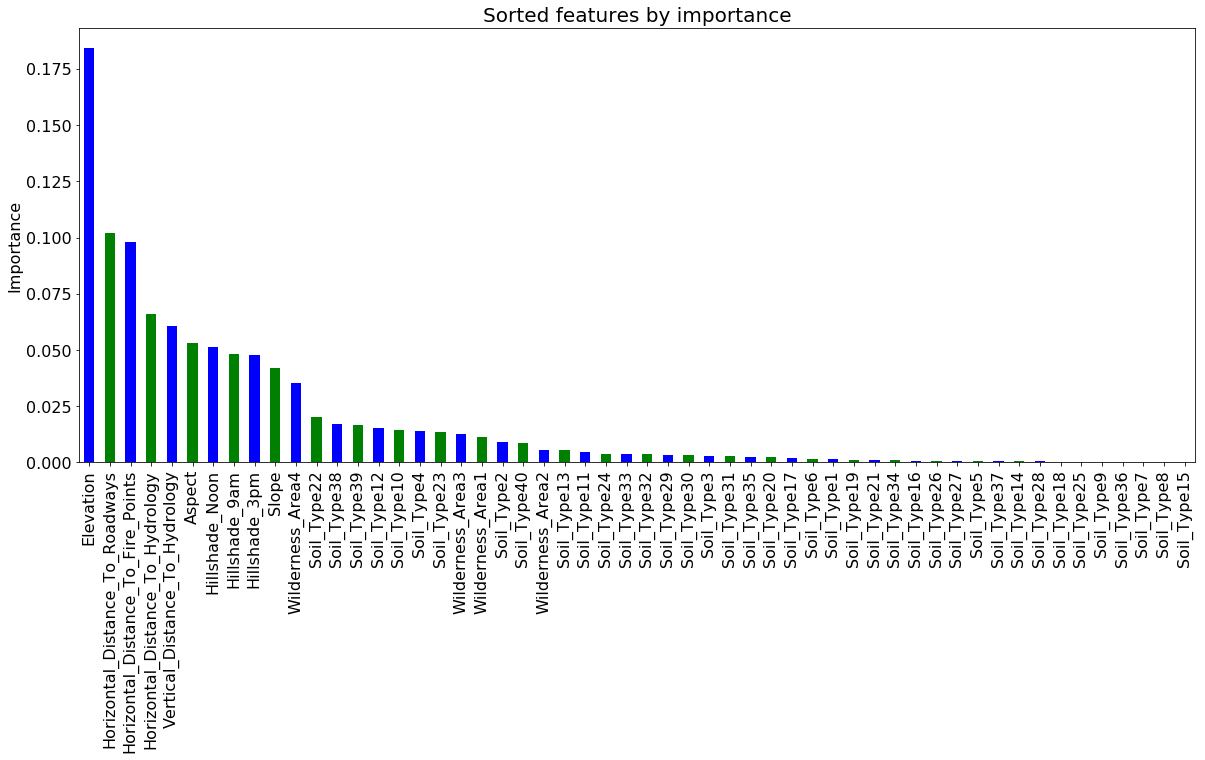

In [8]:
feature_importance(ET, train_X)

### Comment
From the graph above, it clearly appears that the soil type and the wilderness area features are the least important ones. For this reason and in order to reduce the number of features to control, I decided to group all the soil types into one variable and apply the same operation to the wilderness area.

Moreover, noticing that the horizontal distances were on the top 5 most important features, I decided to create a new variable calculated as the mean of all these distances. 

The distances to hydrology in the horizontal and vertical directions were used to compute the hypotenuse, and I also computed the ratio of the 2 features. 

I did not do anything else regarding the aspect and the hillshade features as I considered that there were not that important.

The different changes are implemented in the cell below for the entire training set (X) and the test set (test_X).

In [9]:
# Undo categorical values Soil_Type 
features = X.columns
soils = features[14:]
X = undo_categorical_soil(X)
test_X = undo_categorical_soil(test_X)

# Undo categorical values Wilderness_Area
wild_areas = features[10:14]
X = undo_categorical_wilderness(X)
test_X = undo_categorical_wilderness(test_X)

# Create new features
X['mean_horiz_dist']=(X.Horizontal_Distance_To_Fire_Points + X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways) / 3
X['hypo_dist_hyd'] = np.sqrt(X.Vertical_Distance_To_Hydrology**2 + X.Horizontal_Distance_To_Hydrology**2)
X['ratio_dist_hyd'] = X.Vertical_Distance_To_Hydrology / X.Horizontal_Distance_To_Hydrology
X['ratio_dist_hyd'] = X['ratio_dist_hyd'].map(lambda x: 0 if np.isnan(x) else x)
X['ratio_dist_hyd'] = X['ratio_dist_hyd'].map(lambda x: 0 if np.isinf(x) else x)

test_X['mean_horiz_dist']=(test_X.Horizontal_Distance_To_Fire_Points + test_X.Horizontal_Distance_To_Hydrology + test_X.Horizontal_Distance_To_Roadways) / 3
test_X['hypo_dist_hyd'] = np.sqrt(test_X.Vertical_Distance_To_Hydrology**2 + test_X.Horizontal_Distance_To_Hydrology**2)
test_X['ratio_dist_hyd'] = test_X.Vertical_Distance_To_Hydrology / test_X.Horizontal_Distance_To_Hydrology
test_X['ratio_dist_hyd']= test_X['ratio_dist_hyd'].map(lambda x: 0 if np.isinf(x) else x)
test_X['ratio_dist_hyd'] = test_X['ratio_dist_hyd'].map(lambda x: 0 if np.isnan(x) else x)

# Split into training (80%) and validation (20%) with the new changes
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1109)

# V - Classification using Extra Tree Classifier

## 1. Cross-validation

The cross-validation computations were in general computationally expensive and time consuming. Five folds were used (80% training and 20% test each time) and in total I executed $(2\cdot2\cdot4\cdot4\cdot2)^{2}\cdot5 = 1280$ operations. The cell below shows all the parameters I was playing with. I decided not to print the results from the cell since I did not perform one single cross-validation. I did a few but I quicky realized that the parameters that were actually changing the accuracy of my predictions were the quality of the split (criterion), the maximum number of features chosen (max_features) and the number of trees in the forest (n_estimators).

In [ ]:
# Define grid search parameters
param_grid_ET = {'bootstrap':[True, False],
              'criterion':['entropy','gini'],
              'class_weight':['balanced', None],
              'max_features':[8, 10, 12, 14],
              'n_estimators':[10, 50, 100, 500],
              'min_samples_split':[2, 4]}

grid_search = GridSearchCV(estimator = ET, param_grid = param_grid_ET,
                               cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(train_X, train_y)

optimal_grid = grid_search.best_estimator_

print(f"Optimal parameters: {grid_search.best_params_}")

val_predictions = optimal_grid.predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

In the end, I found the following optimal parameters for my model:
- Bootstrap: False (default value)
- criterion: entropy
- class_weight: None (default value)
- n_estimators: 100
- min_samples_splits: 2 (default value)
- max_features: 12

## 2. Prediction with the optimal parameters obtained from cross-validation

In [16]:
# Extra Tree classifier
ET = ExtraTreesClassifier(n_estimators=500,  
                                      n_jobs=-1, 
                                      criterion = 'entropy', 
                                      max_features=12)                                      

# Make validation predictions with fit and predict
val_predictions = ET.fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.96      0.95      0.96     38605
          2       0.96      0.97      0.96     51525
          3       0.95      0.96      0.95      6519
          4       0.92      0.86      0.89       508
          5       0.91      0.83      0.87      1684
          6       0.93      0.90      0.91      3163
          7       0.97      0.95      0.96      3740

avg / total       0.96      0.96      0.96    105744

Accuracy : 0.9577186412467847


### Comment
The cross-validation step led to an increase of the accuracy. We moved from 0.923 (with no parameter tuning) to 0.957. Moreover, plotting the order of importance of the features considered for the model (see below) shows that the soil type and wilderness areas suddently gained in importance (there are in the top 3 of the most important features). The other features that were introduced (e.g. mean of all horizontal distances and hypotenuse) are also in the top 7 of the most important features.

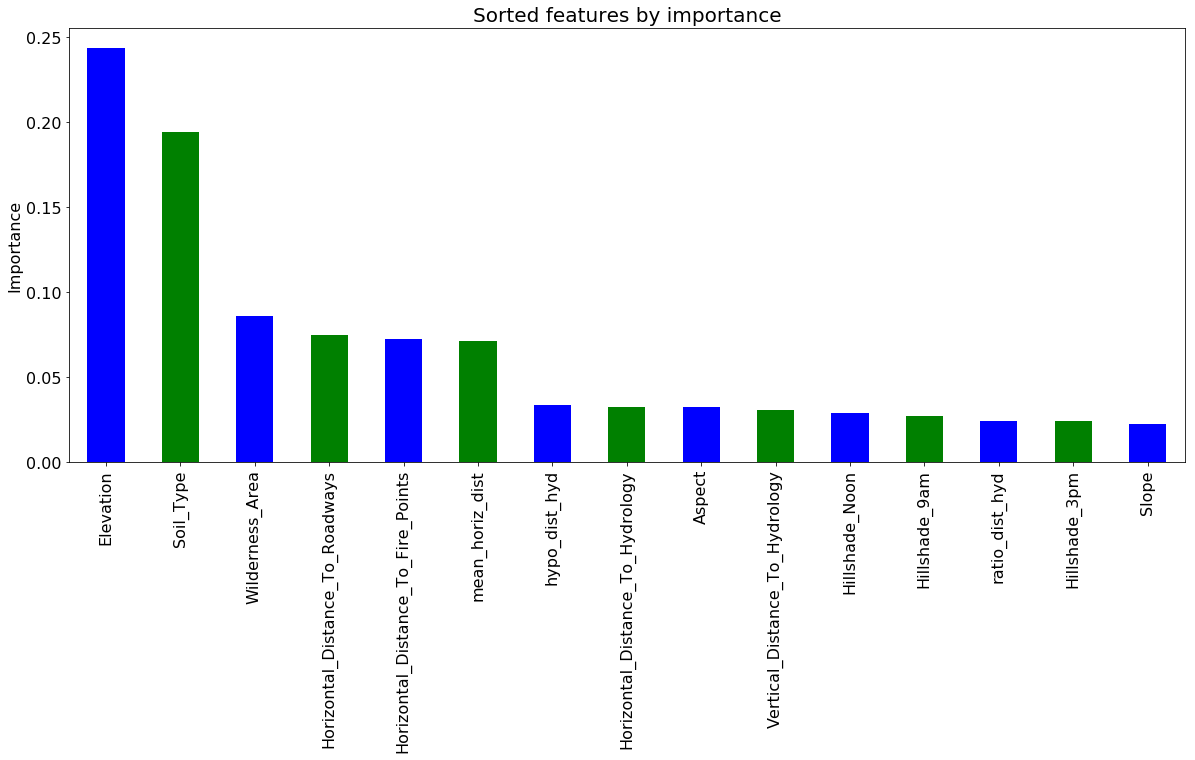

In [12]:
feature_importance(ET, train_X)

## 3. Further improvement with OneVSALL method ?

From the results obtained above, I noticed that my worst predictions were performed on classes 4, 5 and 6. I therefore decided to use the strategy consisting in fitting one classifier per class. For that, I used the one-vs-all method already implemented in scikit-learn to see whether or not I would manage to improve my score.

In [13]:
ET = ExtraTreesClassifier(n_estimators=500,  
                                      n_jobs=-1, 
                                      criterion = 'entropy', 
                                      max_features=12)            

# Make validation predictions and calculate accuracy
val_predictions = OneVsRestClassifier(ET).fit(train_X, train_y).predict(val_X)

# Evaluate performance
evaluate_performance(val_y, val_predictions)

Evaluation of the model performance:
             precision    recall  f1-score   support

          1       0.96      0.95      0.96     38605
          2       0.96      0.97      0.96     51525
          3       0.94      0.96      0.95      6519
          4       0.92      0.85      0.89       508
          5       0.91      0.81      0.86      1684
          6       0.92      0.90      0.91      3163
          7       0.97      0.95      0.96      3740

avg / total       0.96      0.96      0.96    105744

Accuracy : 0.9571796035708882


### Comment
Using the OneVsALL method did not improve the score compared to before: I decreased my score from 0.9577 to 0.9572. I did not manage to improve the F1-score of my worst predicted classes. Consequently, I decided to do not use this approach for my final model fitting.

## 4. Submission to Kaggle

Before submitting the final predictions to Kaggle, I retrained my final model on the entire training set. This last step also showed to further improve the accuracy of my predictions. 

In [ ]:
test_y = ET.fit(X, y).predict(test_X)

# Write to csv
pd.DataFrame({'Id':test_data.Id.values,'Cover_Type':test_y})\
            .sort_index(ascending=False,axis=1).to_csv('submission_ET_new500.csv',index=False)

# IV - Conclusion and outlook

For me, the key drivers to bringing me to the top 3 of the competition were:
- group all the soil types into one variable and apply the same operation to the wilderness area
- the grid search parametrization
- the computational resources I used
- the time I spent working on this
- last but not least: the seed I chose to split my training data for learning the model (it was my bithday date and it seems it brought good luck to me).

To further improve my score on Kaggle, it would have been interesting to perform a cross-validation using the OneVSAll approach to choose the optimal parameters for each class. Unfortunately, I was running out of time to test this approach during the competition.